In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from imblearn.over_sampling import RandomOverSampler


In [145]:
rand_seed = 789456
test_participant = 4

In [146]:
data = pd.read_csv('../Collected Data/preprocessed/traindata/preprocessed_traindata'+str(test_participant)+'.csv')

X = data.drop('Label', axis=1) #features
y = data['Label']
y = y.str.strip()
len(X)
X.tail()


,avg_accX,min_accX,max_accX,var_accX,std_accX,avg_accY,min_accY,max_accY,var_accY,std_accY,...,min_magnitude,max_magnitude,var_magnitude,std_magnitude,var_pressure,range_pressure,std_pressure,slope_pressure,kurtosis_pressure,skew_pressure
3409,-0.658329,-1.619629,0.076416,0.183988,0.428402,0.209648,-0.152710,0.492310,0.013309,0.115222,...,0.736366,1.769853,0.029804,0.172424,0.002847,0.325100,0.053293,-0.000052,6.566207,1.913040
3410,-0.794911,-1.521851,-0.292725,0.036870,0.191774,0.005782,-0.504150,0.380005,0.027008,0.164135,...,0.638173,1.687374,0.026369,0.162181,0.049605,1.311612,0.222443,0.001032,4.995534,1.670319
3411,-0.893557,-1.715576,-0.104736,0.060017,0.244678,0.161675,-0.044678,0.468994,0.012094,0.109837,...,0.512569,1.944697,0.047459,0.217579,0.004211,0.361889,0.064812,0.000328,2.021656,0.566493
3412,-0.809971,-1.554565,-0.175537,0.073450,0.270678,0.082148,-0.605957,0.537964,0.037936,0.194528,...,0.581143,1.697793,0.058993,0.242582,0.021780,0.732341,0.147394,0.000779,-0.090597,-0.673246
3413,-0.816060,-1.334839,-0.460693,0.032082,0.178889,0.068148,-0.305542,0.486938,0.020173,0.141855,...,0.557174,1.563537,0.032447,0.179906,0.019595,0.706862,0.139806,0.000657,1.160887,1.154018


In [147]:
label_encoder = LabelEncoder()

encoded_traininglabels = label_encoder.fit_transform(y)

print("Encoded Labels:", encoded_traininglabels)

Encoded Labels: [0 0 0 ... 3 3 3]


In [148]:
label_mapping = dict(zip(encoded_traininglabels, y))
print("Label Mapping:", label_mapping)

Label Mapping: {0: 'Null', 1: 'lift down', 3: 'stairs down', 4: 'stairs up', 2: 'lift up'}


In [149]:
y = encoded_traininglabels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [150]:
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y).items()))

[(0, 1367), (1, 165), (2, 169), (3, 497), (4, 533)]
[(0, 1720), (1, 203), (2, 213), (3, 612), (4, 666)]


In [151]:
Xtrain_resampled, ytrain_resampled = RandomOverSampler(sampling_strategy= "not majority", random_state=rand_seed).fit_resample(X_train, y_train)
print (sorted(Counter(ytrain_resampled).items())) 

X_resampled, y_resampled = RandomOverSampler(sampling_strategy= "not majority", random_state=rand_seed).fit_resample(X, y)
print (sorted(Counter(y_resampled).items()))

[(0, 1367), (1, 1367), (2, 1367), (3, 1367), (4, 1367)]
[(0, 1720), (1, 1720), (2, 1720), (3, 1720), (4, 1720)]


In [152]:
# Define the parameter grid
param_grid = {
    'n_estimators': [200, 225, 250, 275, 300, 325, 350],  # Testing different values for n_estimators
    'max_depth': [None,5, 10, 15, 20],       # Testing different values for max_depth
}

# Initializing Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=rand_seed)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)

# Perform grid search to find the best hyperparameters
grid_search.fit(X_resampled, y_resampled)

# Get the best model and best parameters
best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)


Best Parameters: {'max_depth': 15, 'n_estimators': 275}


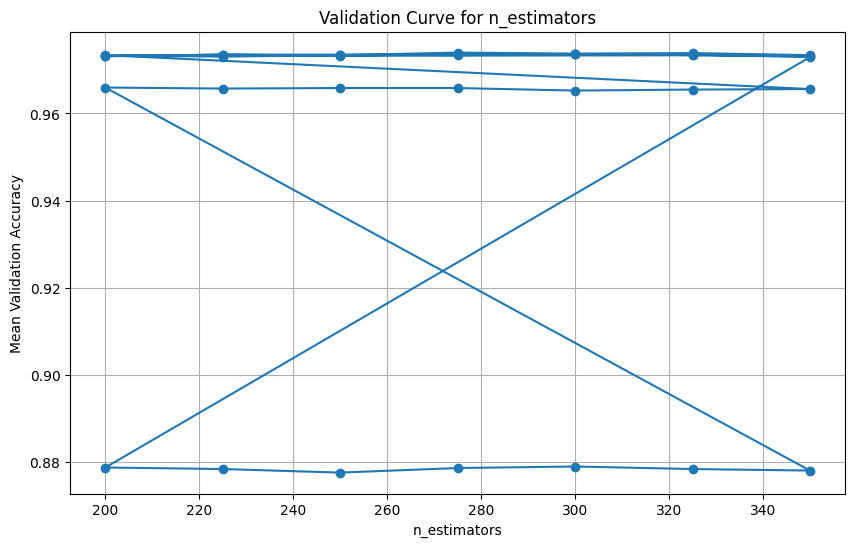

In [153]:
import matplotlib.pyplot as plt

# Extract and plot mean validation scores
mean_scores = grid_search.cv_results_['mean_test_score']
params_n_estimators = [param['n_estimators'] for param in grid_search.cv_results_['params']]

plt.figure(figsize=(10, 6))
plt.plot(params_n_estimators, mean_scores, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Mean Validation Accuracy')
plt.title('Validation Curve for n_estimators')
plt.grid(True)
plt.show()


In [154]:
# Training the model using the best parameters
final_rf = RandomForestClassifier(**best_params, random_state=rand_seed)
final_rf.fit(X_resampled, y_resampled) #use xtrain_resampled & ytrain_resampled for training accuracy. x_resampled and y_resampled for testing accuracy

RandomForestClassifier(max_depth=15, n_estimators=275, random_state=789456)

In [10]:

y_pred = final_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 1.0


In [157]:
data = pd.read_csv('../Collected Data/preprocessed/preprocessed_data'+str(test_participant)+'.csv')

xtest = data.drop('Label', axis=1) #features
ytest = data['Label'].str.strip()


In [158]:
encoded_testinglabels = label_encoder.fit_transform(ytest)
label_mapping = dict(zip(encoded_testinglabels, ytest))
print("Label Mapping:", label_mapping)
print(encoded_testinglabels)

Label Mapping: {0: 'Null', 2: 'lift up', 3: 'stairs down', 1: 'lift down', 4: 'stairs up'}
[0 0 0 0 2 2 2 2 2 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 2 0 0 0 0 2 0
 0 3 3 3 0 0 0 0 2 2 2 0 0 0 1 1 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 1 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 1 1 0 2 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]


In [159]:
y_pred = final_rf.predict(xtest)
ytest = encoded_testinglabels
accuracy = accuracy_score(ytest, y_pred)
print("Accuracy:", accuracy)
f1_micro = f1_score(ytest, y_pred, average='micro')
f1_macro = f1_score(ytest, y_pred, average='macro')
f1_weighted = f1_score(ytest, y_pred, average='weighted')
print("F1 Score micro:", f1_micro)
print("F1 Score macro:", f1_macro)
print("F1 Score weighted:", f1_weighted)

Accuracy: 0.8238341968911918
F1 Score micro: 0.8238341968911918
F1 Score macro: 0.8110270527787569
F1 Score weighted: 0.8256228379795283


In [59]:
print(ytest, y_pred)

[0 0 0 0 0 1 1 0 0 0 4 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 2 2 0 0 0 1 0 0
 0 0 1 1 0 0 4 4 4 4 4 4 4 4 0 3 3 3 3 3 3 3 3 3 0 4 4 4 4 0 3 3 3 3 0 0 0
 0 2 2 0 0 0 1 1 1 0 0 0 2 2 2 0 0 3 3 3 3 0 0 0 4 4 4 4 4 4 4 4 4 0 0 3 3
 3 3 3 3 3 3 3 3 3 0 0 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 1 1 0 0 0 1 0 0
 0 2 0 0 0 3 3 0 0 0 0 0 0 2 2 0 0 1 1 0 0 0 0 2 2 2 2 0 0 1 1 1 1 0 0 4 4
 4 4 4 4 4 4 0] [0 0 0 0 0 1 1 0 0 0 4 0 0 0 3 0 3 3 0 3 3 0 3 3 3 3 0 4 0 2 0 0 0 0 1 0 0
 0 0 1 1 0 0 4 4 4 4 4 0 4 4 0 3 0 3 3 0 3 0 3 3 0 4 0 4 4 0 3 3 0 3 0 0 0
 0 0 2 0 0 0 1 1 0 0 0 0 0 2 4 0 0 3 0 3 3 0 0 0 4 0 4 4 4 4 0 4 4 0 0 3 3
 3 3 3 3 0 3 3 3 3 0 0 4 4 4 4 0 4 4 0 4 0 4 4 0 0 0 0 0 0 1 1 0 0 0 1 0 0
 0 2 0 0 3 3 3 0 0 0 0 0 0 2 0 0 0 1 1 0 0 0 0 4 2 2 0 0 0 1 1 1 1 0 0 4 0
 4 4 0 4 4 4 0]


In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [160]:
import numpy as np
cm = confusion_matrix(ytest, y_pred,  labels=np.arange(len(label_encoder.classes_)))

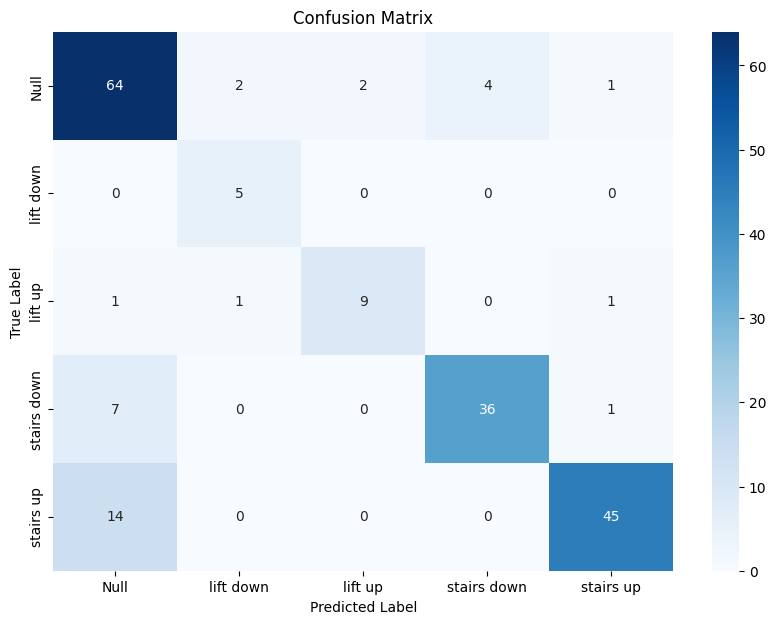

In [161]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [139]:
importances = final_rf.feature_importances_
importances = list(map(lambda x: str(x), importances))
# Create a DataFrame for better visualization
feature_names = X.columns
feature_importances = feature_importances.set_index('Feature').transpose()
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances, 'Participant':test_participant})

# Convert the DataFrame to a CSV formatted string
csv_string = feature_importances.to_csv(index=False)
print(",".join(importances))
# Print the CSV string
print(csv_string)




0.015859274526969596,0.02657687380447537,0.01713201689222744,0.024227806470999418,0.024645801101468207,0.012126834554375953,0.013170528095605353,0.015320671157267833,0.014243279895017478,0.014516004744395964,0.013487893909236763,0.01605901042212594,0.011634473267324091,0.019328418626082974,0.02107974843533421,0.01691664092013579,0.03480042349357979,0.04710167401416041,0.08501143883133078,0.08303358941345045,0.04378452364494705,0.025690393893533572,0.04095153566280262,0.3099334236780292,0.036291119342806835,0.017076601202316983
Feature,Importance,Participant
avg_accX,0.015859274526969596,3
min_accX,0.02657687380447537,3
max_accX,0.01713201689222744,3
var_accX,0.024227806470999418,3
std_accX,0.024645801101468207,3
avg_accY,0.012126834554375953,3
min_accY,0.013170528095605353,3
max_accY,0.015320671157267833,3
var_accY,0.014243279895017478,3
std_accY,0.014516004744395964,3
avg_accZ,0.013487893909236763,3
min_accZ,0.01605901042212594,3
max_accZ,0.011634473267324091,3
var_accZ,0.019328418626

TypeError: string indices must be integers

In [78]:
feature_importances = feature_importances.set_index('Feature')

# Print the transposed DataFrame
print(feature_importances)


                   Importance
Feature                      
avg_accX             0.017024
min_accX             0.024877
max_accX             0.016434
var_accX             0.025421
std_accX             0.026628
avg_accY             0.013637
min_accY             0.014092
max_accY             0.015851
var_accY             0.013228
std_accY             0.014403
avg_accZ             0.014205
min_accZ             0.015146
max_accZ             0.011229
var_accZ             0.018652
std_accZ             0.020574
avg_magnitude        0.015271
min_magnitude        0.035835
max_magnitude        0.045054
var_magnitude        0.087839
std_magnitude        0.077065
var_pressure         0.042277
range_pressure       0.025966
std_pressure         0.042599
slope_pressure       0.316058
kurtosis_pressure    0.035353
skew_pressure        0.015283
